# **Importing necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install optuna
import optuna
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# **Uploading the dataset**

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


# **Exploratory data analysis**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [5]:
# data descriptions

data.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [6]:
# checking for missing values

data.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [7]:
# picking up the certain type of features and assigning them to respective variables

float_df = data.select_dtypes(include=['float64'])
object_df = pd.get_dummies(data.select_dtypes(include=['object'])).astype('int8')
cols = list(float_df.columns)

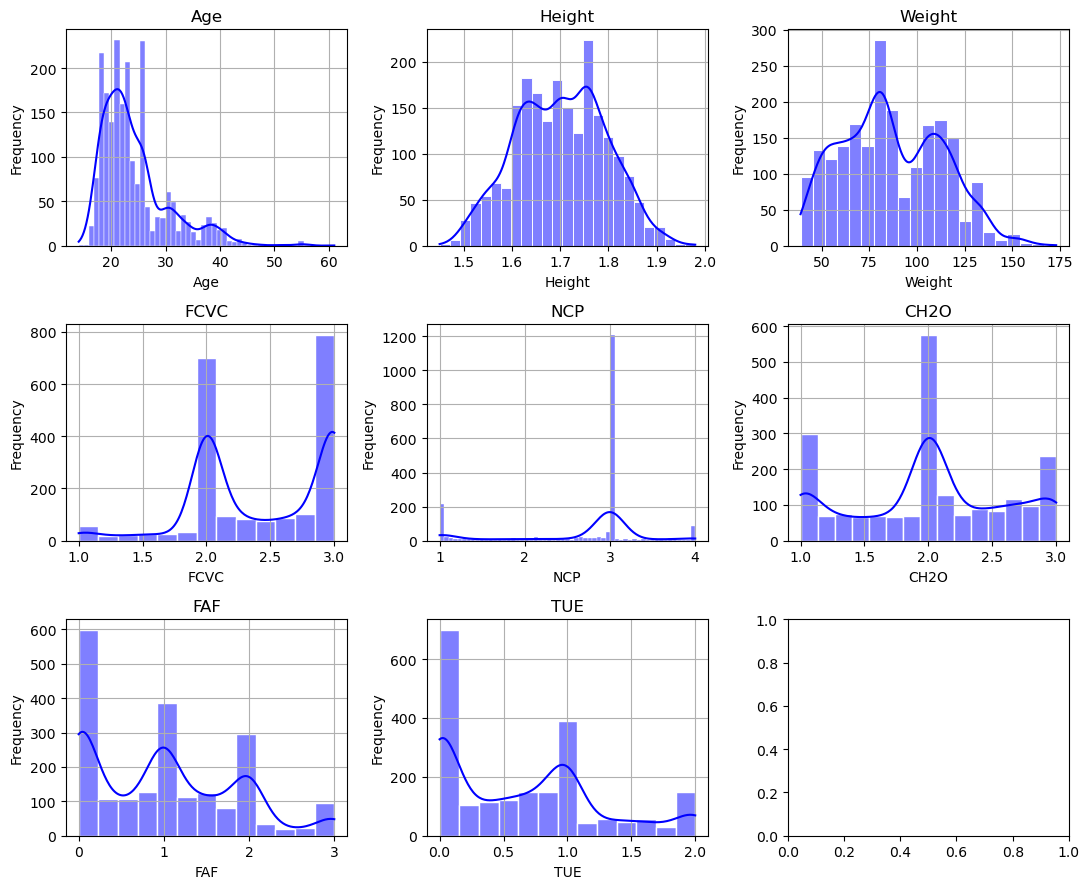

In [8]:
# dsiplaying data distribution of each numeric type feature

fig, axs = plt.subplots(3, 3, figsize=(11, 9), dpi=100)
for i, var in enumerate(cols):
    row = i // 3
    col = i % 3
    sns.histplot(data=float_df, x=var, kde=True, ax=axs[row, col], color="blue", edgecolor="w")
    axs[row, col].set_title(var)
    axs[row, col].set_ylabel("Frequency")
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()

In [9]:
# showing the statistics for features with categorical data

object_df.sum()

Gender_Female                         1043
Gender_Male                           1068
family_history_with_overweight_no      385
family_history_with_overweight_yes    1726
FAVC_no                                245
FAVC_yes                              1866
CAEC_Always                             53
CAEC_Frequently                        242
CAEC_Sometimes                        1765
CAEC_no                                 51
SMOKE_no                              2067
SMOKE_yes                               44
SCC_no                                2015
SCC_yes                                 96
CALC_Always                              1
CALC_Frequently                         70
CALC_Sometimes                        1401
CALC_no                                639
MTRANS_Automobile                      457
MTRANS_Bike                              7
MTRANS_Motorbike                        11
MTRANS_Public_Transportation          1580
MTRANS_Walking                          56
NObeyesdad_

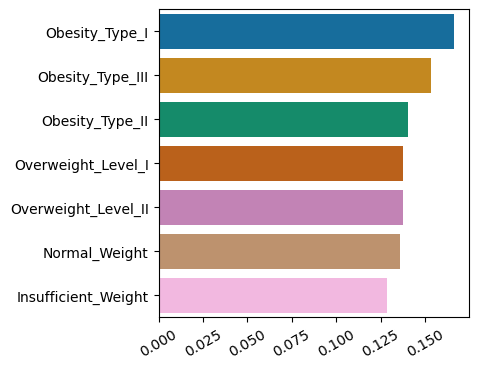

In [10]:
# displaying the target variable

target = data['NObeyesdad'].value_counts(normalize=True).sort_values(ascending=False)
plt.figure(figsize=(4,4))
sns.barplot(y=target.index, x=target.values, palette='colorblind')
plt.xticks(rotation=(30))
plt.show()

# **Data Preprocessing**

In [11]:
# creating a dictionary that is needed for label encoding
target_map = {
    'Insufficient_Weight':0,
    'Normal_Weight':1,
    'Obesity_Type_I':2,
    'Obesity_Type_II':3,
    'Obesity_Type_III':4,
    'Overweight_Level_I':5,
    'Overweight_Level_II':6
}

# creating a list that is needed for classification matrix
class_names = [
    'Insufficient_Weight', 
    'Normal_Weight', 
    'Obesity_Type_I', 
    'Obesity_Type_II',
    'Obesity_Type_III', 
    'Overweight_Level_I', 
    'Overweight_Level_II'
]

# label encoding
data['NObeyesdad'] = data['NObeyesdad'].map(target_map)

In [12]:
# transforming categorical data into numerical
# this is usually called OneHotEncodeing

data = pd.get_dummies(data, drop_first=True).astype('float64')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 2111 non-null   float64
 1   Height                              2111 non-null   float64
 2   Weight                              2111 non-null   float64
 3   FCVC                                2111 non-null   float64
 4   NCP                                 2111 non-null   float64
 5   CH2O                                2111 non-null   float64
 6   FAF                                 2111 non-null   float64
 7   TUE                                 2111 non-null   float64
 8   NObeyesdad                          2111 non-null   float64
 9   Gender_Male                         2111 non-null   float64
 10  family_history_with_overweight_yes  2111 non-null   float64
 11  FAVC_yes                            2111 no

# **Feature Engineering**

In [14]:
# dropping out the specified columns

data = data.drop(['Height', 'Weight'], axis=1)

# **Train/Test Split**

In [15]:
# defining independant and dependant varuable 

X = data.drop('NObeyesdad', axis=1)

y = data['NObeyesdad']

In [16]:
# data splitting

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [17]:
# data scaling using standardization

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# **VIF**

In [18]:
# creating a function which gives DF with feature names and vif score

def calc_vif(X):

    from statsmodels.stats.outliers_influence import variance_inflation_factor

    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.sort_values('VIF', ascending=False).reset_index(drop=True)

    return(vif)

In [19]:
scores = calc_vif(X)

scores[scores['VIF'] < 5]

,Features,VIF
12,FAF,2.822093
13,TUE,2.544112
14,Gender_Male,2.444640
15,CAEC_no,2.083883
16,MTRANS_Walking,1.254418
17,SCC_yes,1.154136
18,SMOKE_yes,1.064051
19,MTRANS_Motorbike,1.051194
20,MTRANS_Bike,1.036068


In [20]:
scores[scores['VIF'] > 5]

,Features,VIF
0,CALC_Sometimes,92.164942
1,CALC_no,40.729294
2,CAEC_Sometimes,35.069294
3,Age,29.001674
4,FCVC,24.562022
5,NCP,14.090830
6,CH2O,13.372483
7,FAVC_yes,9.990291
8,MTRANS_Public_Transportation,7.418870
9,family_history_with_overweight_yes,7.070209


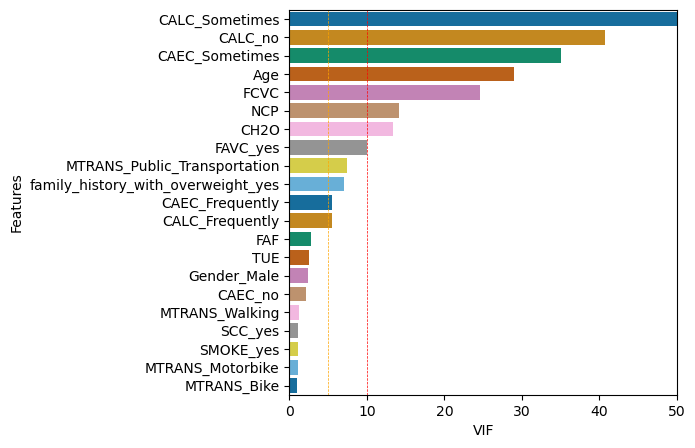

In [21]:
# plotting vif scores

plt.figure(figsize=(5,5))
sns.barplot(data=scores, x='VIF', y='Features', palette='colorblind')
plt.axvline(x=5, color='orange', ls='--', lw=0.5)
plt.axvline(x=10, color='red', ls='--', lw=0.5)
plt.xlim(0, 50)
plt.show()

# **Model Building**

## **SVM**

In [22]:
# training SVM model using RBF kernel
from sklearn.svm import SVC

# initializing SVM model with RBF kernel
model_svm = SVC(kernel = 'rbf')

# training the model on the training data
model_svm.fit(X_train, y_train)

# making predictions on the test data
y_pred_svm = model_svm.predict(X_test)

In [23]:
print(classification_report(y_test, y_pred_svm, target_names=class_names))

                     precision    recall  f1-score   support

Insufficient_Weight       0.81      0.74      0.77        58
      Normal_Weight       0.63      0.70      0.67        64
     Obesity_Type_I       0.65      0.62      0.63        64
    Obesity_Type_II       0.74      1.00      0.85        61
   Obesity_Type_III       0.98      0.98      0.98        61
 Overweight_Level_I       0.81      0.61      0.70        64
Overweight_Level_II       0.67      0.61      0.64        51

           accuracy                           0.75       423
          macro avg       0.76      0.75      0.75       423
       weighted avg       0.76      0.75      0.75       423



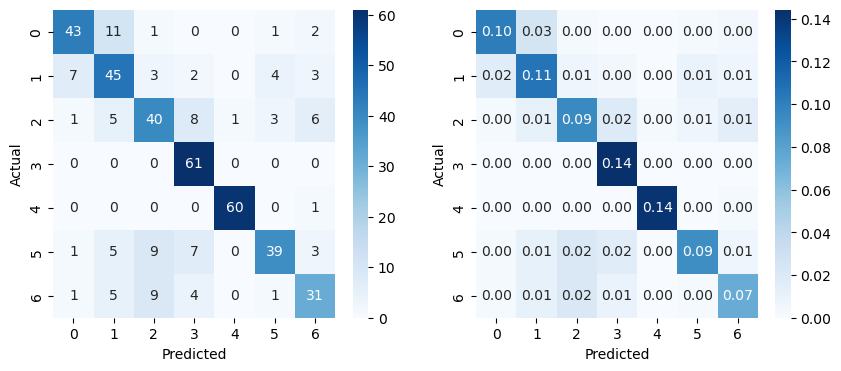

In [24]:
# calculating confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

# plotting confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(10,4))

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            ax=ax[0])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(cm_svm/np.sum(cm_svm), annot=True, fmt='.2f', cmap='Blues',
            ax=ax[1])
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.show()

### Optuna optimization

In [25]:
# Define the objective function for the SVM model to be used by Optuna for optimization

def svm_objective(trial):
    
    # suggesting a float value for the C parameter between 9 and 10
    svc_c = trial.suggest_float("C", 9, 10, log=False) 
    
    # suggesting using the 'rbf' kernel type
    kernel = trial.suggest_categorical('kernel', ['rbf']) 
    
    # suggesting using either 'scale' or 'auto' for the gamma parameter
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) 
    
    # suggesting an integer value for the degree parameter between 1 and 5
    degree = trial.suggest_int('degree', 1, 5)

    # createing an SVC model with the suggested parameters
    clf =  SVC(C = svc_c, kernel=kernel, gamma=gamma, degree=degree)
    
    # calculating the cross-validated F1-score for the model using training data
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_weighted')

    return scores.mean()

# creating a study object that aims to maximize the returned objective value
svm_study = optuna.create_study(direction='maximize')

# executing optimization of the objective function over 50 trials
svm_study.optimize(svm_objective, n_trials=50)

[I 2024-04-23 11:02:13,788] A new study created in memory with name: no-name-467a8d5c-b48f-4d98-9a12-3c05c5b34600
[I 2024-04-23 11:02:14,676] Trial 0 finished with value: 0.7783610500441563 and parameters: {'C': 9.4253499548064, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 3}. Best is trial 0 with value: 0.7783610500441563.
[I 2024-04-23 11:02:15,575] Trial 1 finished with value: 0.7777785889994119 and parameters: {'C': 9.539610207448082, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 4}. Best is trial 0 with value: 0.7783610500441563.
[I 2024-04-23 11:02:16,465] Trial 2 finished with value: 0.7801994231224421 and parameters: {'C': 9.01861712853963, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 2}. Best is trial 2 with value: 0.7801994231224421.
[I 2024-04-23 11:02:17,339] Trial 3 finished with value: 0.7795629739006172 and parameters: {'C': 9.187272460619742, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 5}. Best is trial 2 with value: 0.7801994231224421.
[I 2024-04-23 11:02:18,223] Trial 4 

[I 2024-04-23 11:02:49,189] Trial 38 finished with value: 0.7802014476173739 and parameters: {'C': 9.14517538243253, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 1}. Best is trial 34 with value: 0.7802014476173739.
[I 2024-04-23 11:02:50,106] Trial 39 finished with value: 0.7802014476173739 and parameters: {'C': 9.150974335788533, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 1}. Best is trial 34 with value: 0.7802014476173739.
[I 2024-04-23 11:02:51,021] Trial 40 finished with value: 0.7789961340587246 and parameters: {'C': 9.315072262219498, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 1}. Best is trial 34 with value: 0.7802014476173739.
[I 2024-04-23 11:02:51,914] Trial 41 finished with value: 0.7802014476173739 and parameters: {'C': 9.14839213086708, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 1}. Best is trial 34 with value: 0.7802014476173739.
[I 2024-04-23 11:02:52,819] Trial 42 finished with value: 0.7802014476173739 and parameters: {'C': 9.141339114924996, 'kernel': 'rbf', 'gamma'

In [26]:
# initializing the SVM classifier with the best hyperparameters found by Optuna
model_svm_opt = SVC(**svm_study.best_params)

# training the SVM model using the training data
model_svm_opt = model_svm_opt.fit(X_train,y_train)

# predicting the labels for the test data using the optimized SVM model
y_pred_svm_opt = model_svm_opt.predict(X_test)

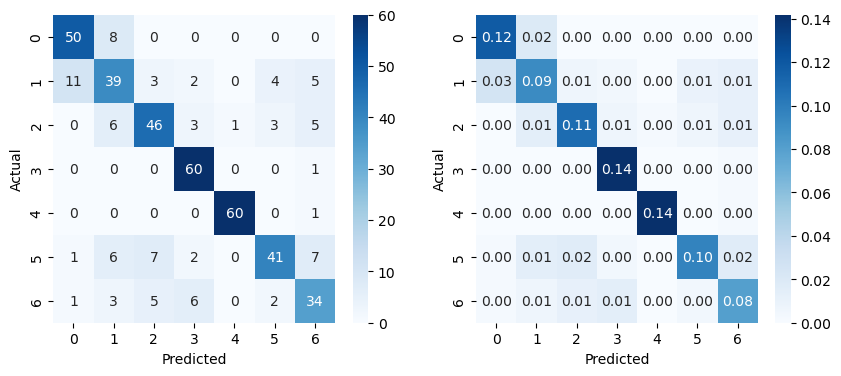

In [27]:
# calculating confusion matrix
cm_svm_opt = confusion_matrix(y_test, y_pred_svm_opt)

# plotting confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(10,4))

sns.heatmap(cm_svm_opt, annot=True, fmt='d', cmap='Blues',
            ax=ax[0])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(cm_svm_opt/np.sum(cm_svm_opt), annot=True, fmt='.2f', cmap='Blues',
            ax=ax[1])
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.show()

In [28]:
print(classification_report(y_test, y_pred_svm_opt, target_names=class_names))

                     precision    recall  f1-score   support

Insufficient_Weight       0.79      0.86      0.83        58
      Normal_Weight       0.63      0.61      0.62        64
     Obesity_Type_I       0.75      0.72      0.74        64
    Obesity_Type_II       0.82      0.98      0.90        61
   Obesity_Type_III       0.98      0.98      0.98        61
 Overweight_Level_I       0.82      0.64      0.72        64
Overweight_Level_II       0.64      0.67      0.65        51

           accuracy                           0.78       423
          macro avg       0.78      0.78      0.78       423
       weighted avg       0.78      0.78      0.78       423



### Grid Search optimization

In [29]:
pipeline = Pipeline([('svm', SVC())])

param_grid = {
    r'svm__C': np.linspace(9, 10, 100),  # setting up Regularization parameter
    'svm__gamma': ['scale', 'auto'],  # setting up kernel coefficient
    'svm__kernel': ['rbf']  # setting up type of kernel
}

# setting up the grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1)

# fitting the grid search model
grid_search.fit(X_train, y_train)
y_pred_gs = grid_search.predict(X_test)

# best parameters and best score
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters: {'svm__C': 9.05050505050505, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}


In [30]:
print(classification_report(y_test, y_pred_gs, target_names=class_names))

                     precision    recall  f1-score   support

Insufficient_Weight       0.79      0.86      0.83        58
      Normal_Weight       0.64      0.61      0.62        64
     Obesity_Type_I       0.76      0.73      0.75        64
    Obesity_Type_II       0.82      0.98      0.90        61
   Obesity_Type_III       0.98      0.98      0.98        61
 Overweight_Level_I       0.82      0.64      0.72        64
Overweight_Level_II       0.64      0.67      0.65        51

           accuracy                           0.78       423
          macro avg       0.78      0.78      0.78       423
       weighted avg       0.78      0.78      0.78       423



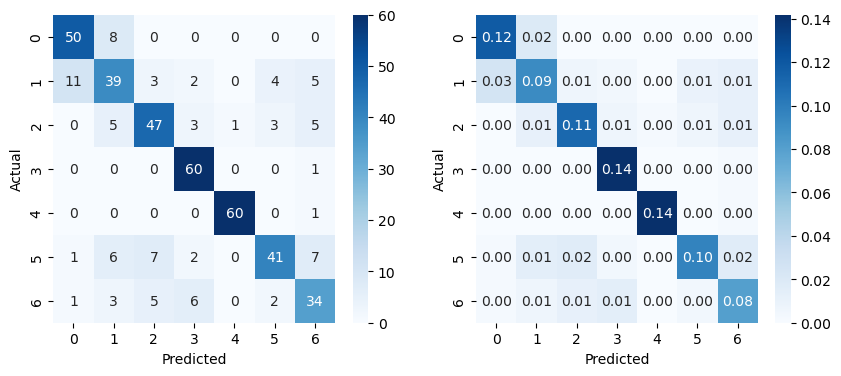

In [31]:
# calculating confusion matrix
cm_svm_gs = confusion_matrix(y_test, y_pred_gs)

# plotting confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(10,4))

sns.heatmap(cm_svm_gs, annot=True, fmt='d', cmap='Blues',
            ax=ax[0])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(cm_svm_gs/np.sum(cm_svm_gs), annot=True, fmt='.2f', cmap='Blues',
            ax=ax[1])
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.show()

### **Cross Validation**

In [32]:
# calculating the mean cross-validated accuracy and f1 score of the SVM model using 5 folds

accuracy = cross_val_score(model_svm, X_train, y_train, cv=5).mean()
f1_scores = cross_val_score(model_svm, X_train, y_train, cv=5, scoring='f1_weighted').mean()
svm_table_cv = pd.DataFrame({'Accuracy':accuracy.round(3),
                              'f1_score':f1_scores.round(3)}, index=['SVM'])

In [33]:
# calculating the mean cross-validated accuracy and f1 score of the SVM optuna optimization model using 5 folds

accuracies = cross_val_score(model_svm_opt, X_train, y_train, cv=5)
f1_scores = cross_val_score(model_svm_opt, X_train, y_train, cv=5, scoring='f1_weighted').mean()
svm_opt_table_cv = pd.DataFrame({'Accuracy':accuracy.round(3),
                              'f1_score':f1_scores.round(3)}, index=['Optuna'])

In [34]:
# calculating the mean cross-validated accuracy and f1 score of the SVM grid search optimization model using 5 folds

accuracies = cross_val_score(grid_search, X_train, y_train, cv=5)
f1_scores = cross_val_score(grid_search, X_train, y_train, cv=5, scoring='f1_weighted').mean()
svm_gs_table_cv = pd.DataFrame({'Accuracy':accuracy.round(3),
                              'f1_score':f1_scores.round(3)}, index=['GridSearch'])

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


### **Performance for Train set**

In [35]:
# calculating the accuracy of the SVM model on the training data

accuracy = accuracy_score(y_train, model_svm.predict(X_train))
f1_scores = f1_score(y_train, model_svm.predict(X_train), average='weighted')
svm_table_train = pd.DataFrame({'Accuracy':accuracy.round(3),
                                 'f1_score':f1_scores.round(3)}, index=['SVM'])

In [36]:
# calculating the accuracy of the SVM optuna optimization model on the training data

accuracy = accuracy_score(y_train, model_svm_opt.predict(X_train))
f1_scores = f1_score(y_train, model_svm_opt.predict(X_train), average='weighted')
svm_table_train_opt = pd.DataFrame({'Accuracy':accuracy.round(3),
                                     'f1_score':f1_scores.round(3)}, index=['Optuna'])

In [37]:
# calculating the accuracy of the SVM grid search optimization model on the training data

accuracy = accuracy_score(y_train, grid_search.predict(X_train))
f1_scores = f1_score(y_train, grid_search.predict(X_train), average='weighted')
svm_table_train_gs = pd.DataFrame({'Accuracy':accuracy.round(3),
                                     'f1_score':f1_scores.round(3)}, index=['GridSearch'])

### **Performance for Test set**

In [38]:
# calculating the accuracy of the SVM model on the testing data

accuracy = accuracy_score(y_test, y_pred_svm)
f1_scores = f1_score(y_test, y_pred_svm, average='weighted')
svm_table_test = pd.DataFrame({'Accuracy':accuracy.round(3),
                                'f1_score':f1_scores.round(3)}, index=['SVM'])

In [39]:
# calculating the accuracy of the SVM optuna optimization model on the testing data

accuracy = accuracy_score(y_test, y_pred_svm_opt)
f1_scores = f1_score(y_test, y_pred_svm_opt, average='weighted')
svm_table_test_opt = pd.DataFrame({'Accuracy':accuracy.round(3),
                                    'f1_score':f1_scores.round(3)}, index=['Optuna'])

In [40]:
# calculating the accuracy of the SVM grid search optimization model on the testing data

accuracy = accuracy_score(y_test, y_pred_gs)
f1_scores = f1_score(y_test, y_pred_gs, average='weighted')
gs_table_test = pd.DataFrame({'Accuracy':accuracy.round(3),
                                    'f1_score':f1_scores.round(3)}, index=['GridSearch'])

### **Summary**

In [41]:
# defining a multi-level column structure for the resulting DataFrame
columns = pd.MultiIndex.from_product([['Train', 'CV', 'Test'], ['Accuracy','f1_score']])

# merging training, cross-validation, and testing metrics for the standard SVM model
svm_summary_table = svm_table_train.merge(svm_table_cv, how='outer', left_index=True, right_index=True)
svm_summary_table = svm_summary_table.merge(svm_table_test, how='outer', left_index=True, right_index=True)
svm_summary_table.columns = columns

# merging training, cross-validation, and testing metrics for the optimized SVM model
svm_opt_summary_table = svm_table_train_opt.merge(svm_opt_table_cv, how='outer', left_index=True, right_index=True)
svm_opt_summary_table = svm_opt_summary_table.merge(svm_table_test_opt, how='outer', left_index=True, right_index=True)
svm_opt_summary_table.columns = columns

# merging training, cross-validation, and testing metrics for the grid-search optimized SVM model
svm_gs_summary_table = svm_table_train_gs.merge(svm_gs_table_cv, how='outer', left_index=True, right_index=True)
svm_gs_summary_table = svm_gs_summary_table.merge(gs_table_test, how='outer', left_index=True, right_index=True)
svm_gs_summary_table.columns = columns

# concatenating all SVM summaries into a single DataFrame for easy comparison
svm_summary = pd.concat([svm_summary_table, svm_opt_summary_table, svm_gs_summary_table])
svm_summary

Train                CV              Test         
           Accuracy f1_score Accuracy f1_score Accuracy f1_score
SVM           0.801    0.798    0.731    0.725    0.754    0.750
Optuna        0.921    0.920    0.731    0.780    0.780    0.777
GridSearch    0.921    0.920    0.731    0.779    0.783    0.779

## **Boosting Algorithms**

### **Extreme Gradient Boosting (XGBoost)**

In [42]:
import xgboost as xgb

# initializing the XGBoost classifier with a specified random state for reproducibility
model_xgb = xgb.XGBClassifier(random_state=0)

# fitting the XGBoost model on the training data
model_xgb = model_xgb.fit(X_train, y_train)

# predicting the target values for the test dataset using the trained XGBoost model
y_pred_xgb = model_xgb.predict(X_test)

In [43]:
print(classification_report(y_test, y_pred_xgb, target_names=class_names))

                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.86      0.90        58
      Normal_Weight       0.68      0.86      0.76        64
     Obesity_Type_I       0.87      0.84      0.86        64
    Obesity_Type_II       0.91      0.95      0.93        61
   Obesity_Type_III       1.00      0.98      0.99        61
 Overweight_Level_I       0.92      0.73      0.82        64
Overweight_Level_II       0.73      0.75      0.74        51

           accuracy                           0.86       423
          macro avg       0.86      0.85      0.86       423
       weighted avg       0.87      0.86      0.86       423



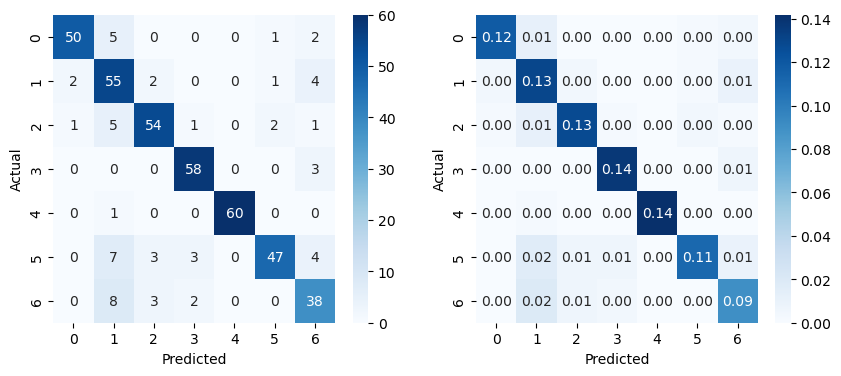

In [44]:
# calculating confusion matrix
xgb_cm = confusion_matrix(y_test, y_pred_xgb)

# plotting confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(10,4))

sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues',
            ax=ax[0])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(xgb_cm/np.sum(xgb_cm), annot=True, fmt='.2f', cmap='Blues',
            ax=ax[1])
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.show()

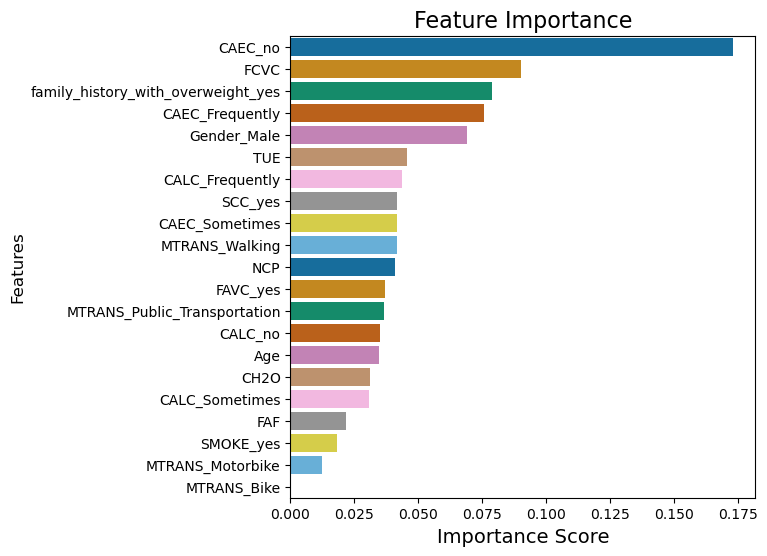

In [45]:
# extracting the feature importances from the trained XGBoost model
coef = model_xgb.feature_importances_

# creating a list of column names from the training data
indx = list(X.columns)

# creating a pandas Series with feature importances, indexed by feature names
feat_ser = pd.Series(coef, index=indx)

# sorting the series to have the most important features at the top
feat_ser = feat_ser.sort_values(ascending=False)

# plotting the features
plt.figure(figsize=(6,6))
sns.barplot(x=feat_ser.values,
            y=feat_ser.index,
            palette='colorblind',)

plt.xlabel('Importance Score', size=14)
plt.ylabel('Features', size=12)
plt.title('Feature Importance', size=16)

plt.show()

### **Cross Validation**

In [46]:
# calculating the mean cross-validated accuracy and f1 score of the XGBoost model using 5 folds

accuracy = cross_val_score(model_xgb, X_train, y_train, cv=5).mean()
f1_scores = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='f1_weighted').mean()
xgb_table_cv = pd.DataFrame({'Accuracy':accuracy.round(3),
                              'f1_score':f1_scores.round(3)}, index=['XGBoost'])

### **Performance for Train set**

In [47]:
# calculating the accuracy of the XGBoost model on the training data

accuracy = accuracy_score(y_train, model_xgb.predict(X_train))
f1_scores = f1_score(y_train, model_svm.predict(X_train), average='weighted')
xgb_table_train = pd.DataFrame({'Accuracy':accuracy.round(3),
                                 'f1_score':f1_scores.round(3)}, index=['XGBoost'])

### **Performance for Test set**

In [48]:
# calculating the accuracy of the XGBoost model on the testing data

accuracy = accuracy_score(y_test, y_pred_xgb)
f1_scores = f1_score(y_test, y_pred_xgb, average='weighted')
xgb_table_test = pd.DataFrame({'Accuracy':accuracy.round(3),
                                'f1_score':f1_scores.round(3)}, index=['XGBoost'])

### **Summary**

In [49]:
# merging the XGBoost model's training performance metrics with cross-validation metrics
xgb_summary_table = xgb_table_train.merge(xgb_table_cv, how='outer', left_index=True, right_index=True)

# further merge the above table with the testing performance metrics
xgb_summary_table = xgb_summary_table.merge(xgb_table_test, how='outer', left_index=True, right_index=True)

# assigning multi-level column labels to the consolidated table
xgb_summary_table.columns = columns
xgb_summary_table

Train                CV              Test         
        Accuracy f1_score Accuracy f1_score Accuracy f1_score
XGBoost      1.0    0.798    0.829    0.829    0.856    0.857

# **Summarising the result**

In [50]:
# concatenating the SVM and XGBoost summary tables into a single DataFrame

summary = pd.concat([svm_summary, xgb_summary_table])

In [51]:
summary

Train                CV              Test         
           Accuracy f1_score Accuracy f1_score Accuracy f1_score
SVM           0.801    0.798    0.731    0.725    0.754    0.750
Optuna        0.921    0.920    0.731    0.780    0.780    0.777
GridSearch    0.921    0.920    0.731    0.779    0.783    0.779
XGBoost       1.000    0.798    0.829    0.829    0.856    0.857

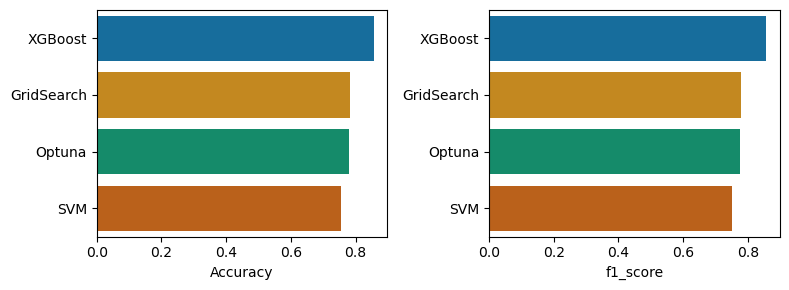

In [52]:
# filtering out the 'Test' column subset from the summary DataFrame
summary = summary['Test']

# sorting the accuracy values in descending order to prioritize the highest values
a = summary['Accuracy'].sort_values(ascending=False)

# sorting the F1 scores in descending order to prioritize the highest values
d = summary['f1_score'].sort_values(ascending=False)

# creating a figure with two subplots side by side, each sized 8x3 inches
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

# creating a bar plot for the accuracy values on the first subplot
sns.barplot(y=a.index, x=a, palette='colorblind', ax=ax[0])

# creating a bar plot for the F1 scores on the second subplot
sns.barplot(y=d.index, x=d, palette='colorblind', ax=ax[1])

plt.tight_layout()